In [2]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import pyaldata as pyd
import scipy
from utils import *
import seaborn as sns

from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

from sklearn.decomposition import PCA, FactorAnalysis

import warnings

# Load and process data

In [4]:
dataset = 'M033_2024_04_11_08_22'
mouse_id = 'M033'

In [3]:
# Function to compute velocity from position
def compute_velocity(positions, dt):
    # Calculate differences between consecutive positions
    velocity = np.diff(positions, axis=0) / dt
    # Append a zero velocity for the last position to keep the array shape consistent
    velocity = np.vstack([velocity, np.zeros((1, 3))])
    return velocity

# Function to create lagged data
def create_lagged_data(X, n_lags):
    n_samples, n_features = X.shape
    X_lagged = np.zeros((n_samples, n_features * n_lags))
    for lag in range(n_lags):
        X_lagged[lag:, lag*n_features:(lag+1)*n_features] = X[:n_samples-lag, :]
    return X_lagged


def process_data(dataset, mouse_id):
    data_dir = '/data/mouse_data/processed/'+mouse_id+'/'+dataset+'/'
    fname = os.path.join(data_dir, dataset+'_pyaldata.mat')

    df = pyd.mat2dataframe(fname, shift_idx_fields=False, td_name='df')

    df['bin_size'] = 0.01

    df = pyd.remove_low_firing_neurons(df, "m1_spikes",  1)
    df = pyd.remove_low_firing_neurons(df, "s1_spikes", 1)
    df = pyd.remove_low_firing_neurons(df, "str_motor_spikes",  1)
    df = pyd.remove_low_firing_neurons(df, "str_sensor_spikes", 1)

    df = pyd.transform_signal(df, "m1_spikes",  'sqrt')
    df = pyd.transform_signal(df, "s1_spikes", 'sqrt')
    df = pyd.transform_signal(df, "str_motor_spikes",  'sqrt')
    df = pyd.transform_signal(df, "str_sensor_spikes", 'sqrt')

    df = pyd.merge_signals(df, ['m1_spikes', 's1_spikes'], 'cortical_spikes')
    df = pyd.merge_signals(df, ['str_motor_spikes', 'str_sensor_spikes'], 'striatal_spikes')
    df = pyd.merge_signals(df, ['m1_spikes', 's1_spikes','str_motor_spikes', 'str_sensor_spikes'], 'all_spikes')


    df = pyd.add_firing_rates(df,'smooth')

    list_of_keypoints = [col for col in df.columns if '_pos' in col]

    dt = 0.01 # 10ms bins

    for keypoint in list_of_keypoints:

        string = keypoint
        keypoint = string.rsplit('_', 1)[0]

        df[keypoint+'_vel'] = df[keypoint+'_pos'].apply(lambda pos: compute_velocity(pos, dt))

    pca_dims = 15

    df = pyd.dim_reduce(df, PCA(pca_dims), "m1_rates", "m1_pca")
    df = pyd.dim_reduce(df, PCA(pca_dims), "s1_rates", "s1_pca")
    df = pyd.dim_reduce(df, PCA(pca_dims), "str_motor_rates", "str_motor_pca")
    df = pyd.dim_reduce(df, PCA(pca_dims), "str_sensor_rates", "str_sensor_pca")

    return df



# Decode joint angles 

In [4]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold

Text(0.5, 0.98, 'left_ankle_angle')

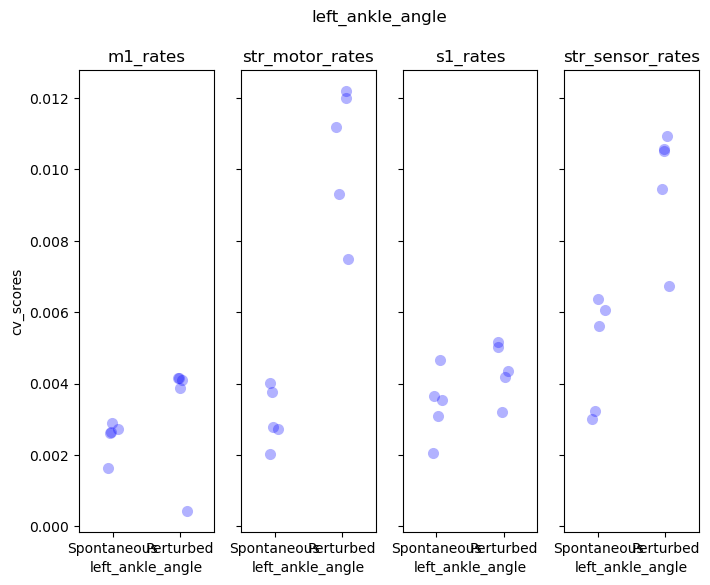

In [13]:
region = "left_ankle_angle"

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(8, 6), sharey=True)
axes = axes.flatten()

for i, input_field in enumerate(["m1_rates", "str_motor_rates", "s1_rates", "str_sensor_rates"]):
    X_perturbed = pyd.concat_trials(df_perturbed, input_field)
    y_perturbed = pyd.concat_trials(df_perturbed, region )

    cv_scores_perturbed = cross_val_score(LinearRegression(), X_perturbed, y_perturbed, cv = KFold(5, shuffle=True), scoring='r2')


    X_spontaneous = pyd.concat_trials(df_spontaneous, input_field)
    y_spontaneous = pyd.concat_trials(df_spontaneous, region )

    cv_scores_spontaneous = cross_val_score(LinearRegression(), X_spontaneous, y_spontaneous, cv = KFold(5, shuffle=True), scoring='r2')

    
    # Combine the data into a single DataFrame
    data = pd.DataFrame({
        'cv_scores': np.concatenate([cv_scores_spontaneous, cv_scores_perturbed]),
        region: ['Spontaneous'] * len(cv_scores_spontaneous) + ['Perturbed'] * len(cv_scores_perturbed) 
    })

    sns.stripplot(data=data, x=region, y='cv_scores', s = 8,alpha=0.3, color='blue', ax=axes[i])
    axes[i].set_title(input_field)
plt.suptitle(region)




In [5]:
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor

# Example input fields
input_fields = ["m1_rates", "str_motor_rates", "s1_rates", "str_sensor_rates"]

# Define the region of interest
region = "tail_tip_pos"

# Example dataset and mouse_id pairs
dataset_mouse_pairs = [
    ('M030_2024_04_11_17_00', 'M030'),
    ('M030_2024_04_12_09_40', 'M030'),
    ('M027_2024_03_20_11_30', 'M027'),
    ('M033_2024_04_11_08_22', 'M033')
]

# Store results
results = {field: {'Spontaneous': [], 'Perturbed': []} for field in input_fields}

for dataset, mouse_id in dataset_mouse_pairs:
    df = process_data(dataset, mouse_id)
    df_perturbed = df[df['trialType'] == 'perturbation']
    df_spontaneous = df[df['trialType'] == 'spontaneous']
    
    for input_field in input_fields:
        X_perturbed = pyd.concat_trials(df_perturbed, input_field)
        y_perturbed = pyd.concat_trials(df_perturbed, region)

        cv_scores_perturbed = cross_val_score(RandomForestRegressor(n_estimators=20), X_perturbed, y_perturbed, cv=KFold(5, shuffle=True), scoring='r2')
        mean_cv_score_perturbed = np.mean(cv_scores_perturbed)
        results[input_field]['Perturbed'].append(mean_cv_score_perturbed)

        X_spontaneous = pyd.concat_trials(df_spontaneous, input_field)
        y_spontaneous = pyd.concat_trials(df_spontaneous, region)

        cv_scores_spontaneous = cross_val_score(RandomForestRegressor(n_estimators=20), X_spontaneous, y_spontaneous, cv=KFold(5, shuffle=True), scoring='r2')
        mean_cv_score_spontaneous = np.mean(cv_scores_spontaneous)
        results[input_field]['Spontaneous'].append(mean_cv_score_spontaneous)

# Plot the performance comparison
fig, axes = plt.subplots(nrows=1, ncols=len(input_fields), figsize=(16, 6), sharey=True)
axes = axes.flatten()

for i, input_field in enumerate(input_fields):
    data = pd.DataFrame({
        'cv_scores': results[input_field]['Spontaneous'] + results[input_field]['Perturbed'],
        'Condition': ['Spontaneous'] * len(results[input_field]['Spontaneous']) + ['Perturbed'] * len(results[input_field]['Perturbed'])
    })
    sns.stripplot(data=data, x='Condition', y='cv_scores', s=8, alpha=0.3, color='blue', ax=axes[i])
    axes[i].set_title(input_field)

plt.suptitle(f"Performance Comparison for {region}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./probe_analysis/decode_keypoints/position_'+region+'.pdf')
plt.show()

NameError: name 'process_data' is not defined

In [7]:
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor

#list_of_keypoints = [col for col in df.columns if '_pos' in col]

list_of_keypoints = ['shoulder_center', 'left_shoulder', 'right_shoulder', 'left_paw', 'right_paw', 'left_elbow', 'right_elbow', 'hip_center', 'left_knee', 'right_knee',
                     'left_ankle', 'right_ankle', 'tail_base', 'tail_middle', 'tail_tip', 'left_wrist', 'right_wrist']

for region in list_of_keypoints:
    # Example input fields
    input_fields = ["m1_rates", "str_motor_rates", "s1_rates", "str_sensor_rates", "cortical_rates", "striatal_rates", "all_rates"]

    # Example dataset and mouse_id pairs
    dataset_mouse_pairs = [
        ('M030_2024_04_11_17_00', 'M030'),
        ('M030_2024_04_12_09_40', 'M030'),
        ('M027_2024_03_20_11_30', 'M027'),
        ('M033_2024_04_11_08_22', 'M033')
    ]

    # Store results
    results = {field: {'Spontaneous': [], 'Perturbed': []} for field in input_fields}
    dataset_indices = {field: {'Spontaneous': [], 'Perturbed': []} for field in input_fields}

    n_lags = 1  # Number of historical steps to include

    for dataset_index, (dataset, mouse_id) in enumerate(dataset_mouse_pairs):
        df = process_data(dataset, mouse_id)
        df_perturbed = df[df['trialType'] == 'perturbation']
        df_spontaneous = df[df['trialType'] == 'spontaneous']
        
        for input_field in input_fields:
            X_perturbed = pyd.concat_trials(df_perturbed, input_field)
            y_perturbed = pyd.concat_trials(df_perturbed, region)
            X_perturbed_lagged = create_lagged_data(X_perturbed, n_lags)
            
            X_spontaneous = pyd.concat_trials(df_spontaneous, input_field)
            y_spontaneous = pyd.concat_trials(df_spontaneous, region)
            X_spontaneous_lagged = create_lagged_data(X_spontaneous, n_lags)
            
            for X, y, label in [(X_perturbed_lagged, y_perturbed, 'Perturbed'), (X_spontaneous_lagged, y_spontaneous, 'Spontaneous')]:
                valid_idx = np.arange(n_lags, len(y))  # Exclude the first `n_lags` samples
                X_valid = X[valid_idx]
                y_valid = y[valid_idx]
                
                cv_scores = cross_val_score(LinearRegression(), X_valid, y_valid, cv=KFold(5, shuffle=True), scoring='r2')
                mean_cv_score = np.mean(cv_scores)
                results[input_field][label].append(mean_cv_score)
                dataset_indices[input_field][label].append(dataset_index)

    # Plot the performance comparison
    fig, axes = plt.subplots(nrows=1, ncols=len(input_fields), figsize=(12, 6), sharey=True)
    axes = axes.flatten()

    for i, input_field in enumerate(input_fields):
        data = pd.DataFrame({
            'cv_scores': results[input_field]['Spontaneous'] + results[input_field]['Perturbed'],
            'Condition': ['Spontaneous'] * len(results[input_field]['Spontaneous']) + ['Perturbed'] * len(results[input_field]['Perturbed']),
            'DatasetIndex': dataset_indices[input_field]['Spontaneous'] + dataset_indices[input_field]['Perturbed']
        })
        sns.stripplot(data=data, x='Condition', y='cv_scores', s=15, alpha=0.3, color='blue', ax=axes[i])
        axes[i].set_title(input_field)
        axes[i].set_ylim([0,0.9])

        # Connect points that belong to the same dataset
        for dataset_index in set(data['DatasetIndex']):
            subset = data[data['DatasetIndex'] == dataset_index]
            if len(subset) == 2:  # Ensure there are both Spontaneous and Perturbed points
                x_coords = [0, 1]  # x-coordinates for 'Spontaneous' and 'Perturbed'
                y_coords = subset['cv_scores'].values
                axes[i].plot(x_coords, y_coords, 'k-', alpha=0.3)

    plt.suptitle(f"Performance Comparison for {region}")
    plt.savefig('./probe_analysis/decode_keypoints/position_'+region+'.pdf')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

NameError: name 'process_data' is not defined

In [ ]:
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor

list_of_keypoints = [col for col in df.columns if '_angle' in col]

for region in list_of_keypoints:
    # Example input fields
    input_fields = ["m1_rates", "str_motor_rates", "s1_rates", "str_sensor_rates"]

    # Example dataset and mouse_id pairs
    dataset_mouse_pairs = [
        ('M030_2024_04_11_17_00', 'M030'),
        ('M030_2024_04_12_09_40', 'M030'),
        ('M027_2024_03_20_11_30', 'M027'),
        ('M033_2024_04_11_08_22', 'M033')
    ]

    # Store results
    results = {field: {'Spontaneous': [], 'Perturbed': []} for field in input_fields}
    n_lags = 1  # Number of historical steps to include

    for dataset, mouse_id in dataset_mouse_pairs:
        df = process_data(dataset, mouse_id)
        df_perturbed = df[df['trialType'] == 'perturbation']
        df_spontaneous = df[df['trialType'] == 'spontaneous']
        
    
        X_perturbed = pyd.concat_trials(df_perturbed, input_field)
        y_perturbed = pyd.concat_trials(df_perturbed, region)
        X_perturbed_lagged = create_lagged_data(X_perturbed, n_lags)
        
        X_spontaneous = pyd.concat_trials(df_spontaneous, input_field)
        y_spontaneous = pyd.concat_trials(df_spontaneous, region)
        X_spontaneous_lagged = create_lagged_data(X_spontaneous, n_lags)
        
        for X, y, label in [(X_perturbed_lagged, y_perturbed, 'Perturbed'), (X_spontaneous_lagged, y_spontaneous, 'Spontaneous')]:
            valid_idx = np.arange(n_lags, len(y))  # Exclude the first `n_lags` samples
            X_valid = X[valid_idx]
            y_valid = y[valid_idx]
            
            cv_scores = cross_val_score(LinearRegression(), X_valid, y_valid, cv=KFold(5, shuffle=True), scoring='r2')
            mean_cv_score = np.mean(cv_scores)
            results[input_field][label].append(mean_cv_score)

    # Plot the performance comparison
    fig, axes = plt.subplots(nrows=1, ncols=len(input_fields), figsize=(8, 6), sharey=True)
    axes = axes.flatten()

    for i, input_field in enumerate(input_fields):
        data = pd.DataFrame({
            'cv_scores': results[input_field]['Spontaneous'] + results[input_field]['Perturbed'],
            'Condition': ['Spontaneous'] * len(results[input_field]['Spontaneous']) + ['Perturbed'] * len(results[input_field]['Perturbed'])
        })
        sns.stripplot(data=data, x='Condition', y='cv_scores', s=8, alpha=0.3, color='blue', ax=axes[i])
        axes[i].set_title(input_field)
        axes[i].set_ylim([0,0.6])

    plt.suptitle(f"Performance Comparison for {region}")
    plt.savefig('./probe_analysis/decode_keypoints/angles_'+region+'.pdf')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

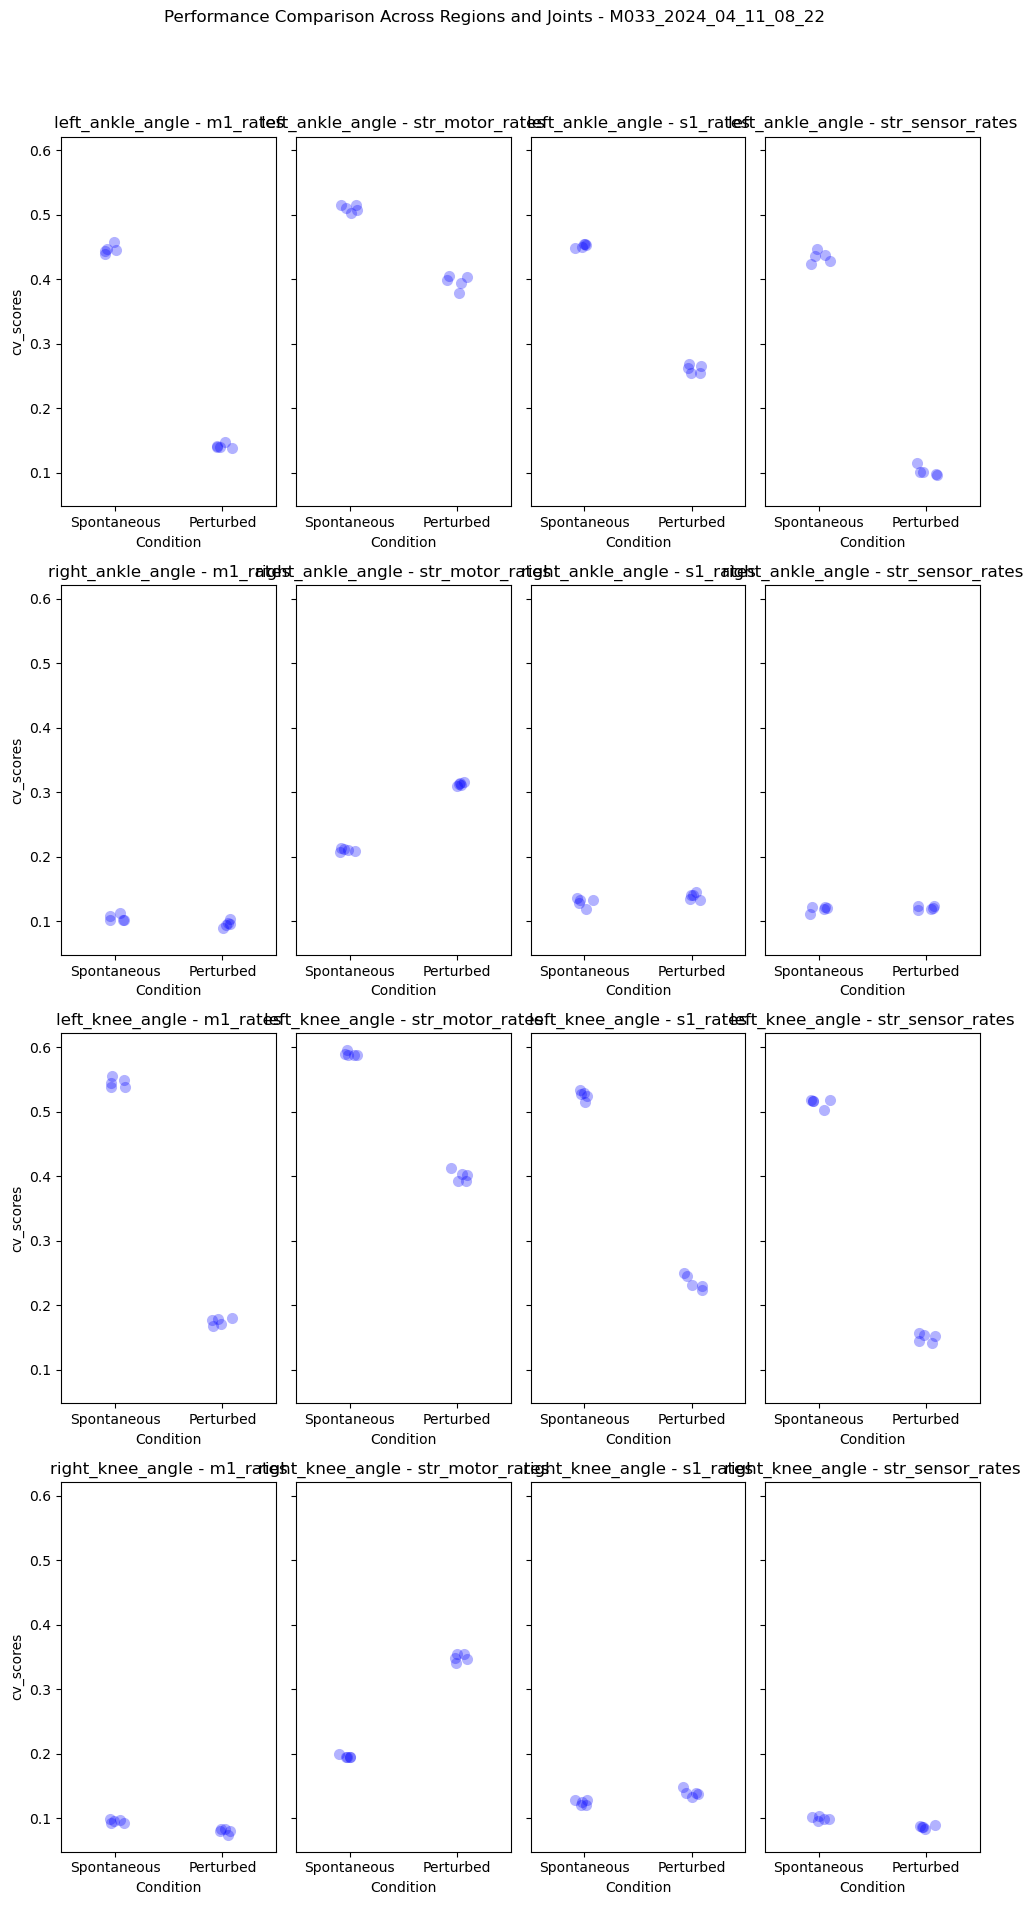

In [16]:
# Example regions and input fields
regions = ["left_ankle_angle", "right_ankle_angle", "left_knee_angle", "right_knee_angle"]
input_fields = ["m1_rates", "str_motor_rates", "s1_rates", "str_sensor_rates"]

# Assuming pyd.concat_trials, df_perturbed, df_spontaneous are defined
# Define the number of rows and columns for the subplots
nrows = len(regions)
ncols = len(input_fields)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5 * nrows), sharey=True)
axes = axes.reshape(nrows, ncols)

for row, region in enumerate(regions):
    for col, input_field in enumerate(input_fields):
        X_perturbed = pyd.concat_trials(df_perturbed, input_field)
        y_perturbed = pyd.concat_trials(df_perturbed, region)

        cv_scores_perturbed = cross_val_score(LinearRegression(), X_perturbed, y_perturbed, cv=KFold(5, shuffle=True), scoring='r2')

        X_spontaneous = pyd.concat_trials(df_spontaneous, input_field)
        y_spontaneous = pyd.concat_trials(df_spontaneous, region)

        cv_scores_spontaneous = cross_val_score(LinearRegression(), X_spontaneous, y_spontaneous, cv=KFold(5, shuffle=True), scoring='r2')

        # Combine the data into a single DataFrame
        data = pd.DataFrame({
            'cv_scores': np.concatenate([cv_scores_spontaneous, cv_scores_perturbed]),
            'Condition': ['Spontaneous'] * len(cv_scores_spontaneous) + ['Perturbed'] * len(cv_scores_perturbed)
        })

        sns.stripplot(data=data, x='Condition', y='cv_scores', s=8, alpha=0.3, color='blue', ax=axes[row, col])
        axes[row, col].set_title(f"{region} - {input_field}")

plt.suptitle("Performance Comparison Across Regions and Joints - " + dataset)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./probe_analysis/decode_keypoints/'+'angles_'+dataset+'.pdf')
plt.show()

# Decode keypoint position

Text(0.5, 0.98, 'right_shoulder_pos')

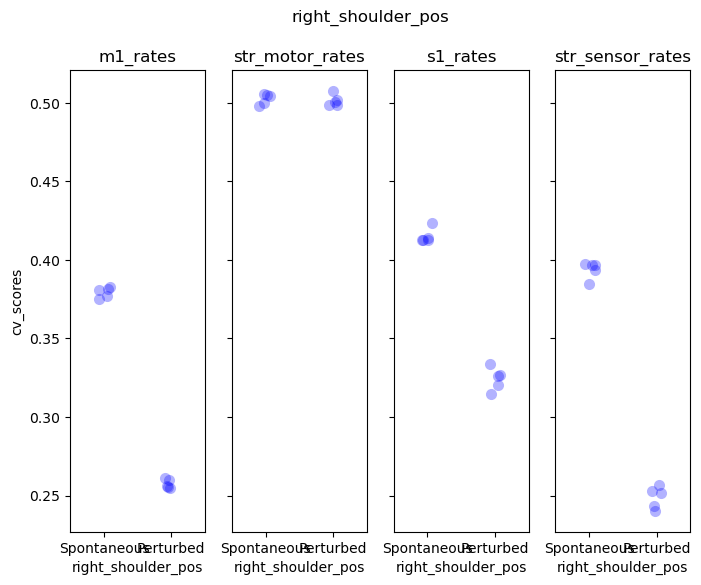

In [92]:
region = "right_shoulder_pos"

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(8, 6), sharey=True)
axes = axes.flatten()

for i, input_field in enumerate(["m1_rates", "str_motor_rates", "s1_rates", "str_sensor_rates"]):
    X_perturbed = pyd.concat_trials(df_perturbed, input_field)
    y_perturbed = pyd.concat_trials(df_perturbed, region )

    cv_scores_perturbed = cross_val_score(LinearRegression(), X_perturbed, y_perturbed, cv = KFold(5, shuffle=True), scoring='r2')


    X_spontaneous = pyd.concat_trials(df_spontaneous, input_field)
    y_spontaneous = pyd.concat_trials(df_spontaneous, region )

    cv_scores_spontaneous = cross_val_score(LinearRegression(), X_spontaneous, y_spontaneous, cv = KFold(5, shuffle=True), scoring='r2')

    
    # Combine the data into a single DataFrame
    data = pd.DataFrame({
        'cv_scores': np.concatenate([cv_scores_spontaneous, cv_scores_perturbed]),
        region: ['Spontaneous'] * len(cv_scores_spontaneous) + ['Perturbed'] * len(cv_scores_perturbed) 
    })

    sns.stripplot(data=data, x=region, y='cv_scores', s = 8,alpha=0.3, color='blue', ax=axes[i])
    axes[i].set_title(input_field)
plt.suptitle(region)




# Decode keypoint velocity

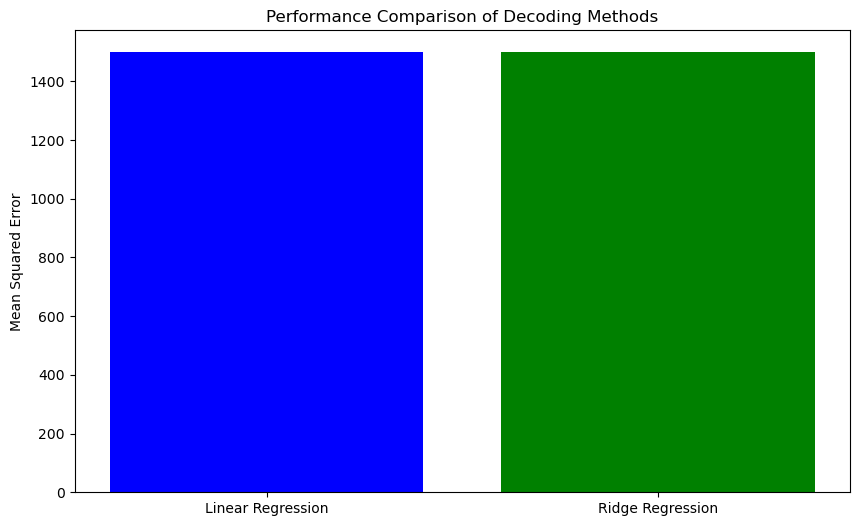

In [84]:


X = pyd.concat_trials(df, "m1_rates")
Y = pyd.concat_trials(df, "right_ankle_angle")

# Define the decoding methods
methods = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
}

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store results
results = {name: [] for name in methods.keys()}

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    for name, model in methods.items():
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        mse = mean_squared_error(Y_test, Y_pred)
        results[name].append(mse)

# Average results across folds
average_results = {name: np.mean(scores) for name, scores in results.items()}

# Plot the performance comparison
plt.figure(figsize=(10, 6))
plt.bar(average_results.keys(), average_results.values(), color=['blue', 'green', 'red'])
plt.ylabel('Mean Squared Error')
plt.title('Performance Comparison of Decoding Methods')
plt.show()